# 1. Kết Nối Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 2. Covert file nhãn XML sang CSV

In [ ]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        name_file_xml = xml_file.strip(path).strip('.xml')

        for member in root.findall('object'):
            value = ('im' + name_file_xml + '.jpg',
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

for directory in ['train','test']:
        image_path = os.path.join('/content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/dataset/label/xml{}'.format(directory))
        xml_df = xml_to_csv(image_path)
        
        xml_df.to_csv('/content/gdrive/MyDrive//DS201_DeepLearning_VNTF_22/dataset/data_training/{}_labels_ssd.csv'.format(directory), index=None)
        print('Successfully converted xml to csv.')

# 3. Tải model và các API cần thiết

## Tải TF Object Detection API vào thư mục models

In [ ]:
# %cd /content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/source/SSD
# !git clone https://github.com/tensorflow/models.git

## Compile the protos

In [ ]:
%cd /content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/source/SSD/models/research
!protoc object_detection/protos/*.proto --python_out=.

/content/gdrive/MyDrive/models/research


## Cài đặt API

In [2]:
%cd /content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/source/SSD/models/research
!cp object_detection/packages/tf2/setup.py . 
!python -m pip install .

/content/gdrive/.shortcut-targets-by-id/17cgN2pmRwHLFSIN0RBdS5fia7zdm142j/DS201_DeepLearning_VNTF_22/source/SSD/models/research
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/gdrive/.shortcut-targets-by-id/17cgN2pmRwHLFSIN0RBdS5fia7zdm142j/DS201_DeepLearning_VNTF_22/source/SSD/models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 87.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 KB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.8 MB/s 

## Test API

In [ ]:
!python object_detection/builders/model_builder_tf2_test.py

# 4. Chuẩn bị dữ liệu train mô hình

In [ ]:
# %cd /content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/source/SSD/models/research
# !git clone https://github.com/thangnch/MiAI_SSD_TF2

## Chuyển CSV sang TFRecord

In [ ]:
%cd /content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/source/SSD/models/research
!cp MiAI_SSD_TF2/generate_tfrecord.py .
!cp MiAI_SSD_TF2/label_map.txt /content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/dataset/label
if not os.path.exists("/content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/dataset/data_training/tfrecord_data/"):
  os.mkdir("/content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/dataset/data_training/tfrecord_data/")

!python generate_tfrecord.py --image_dir=/content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/dataset/data_training/images_train_jpg --csv_input=/content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/dataset/data_training/train_labels_ssd.csv --output_path=/content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/dataset/data_training/tfrecord_data/train.record 
!python generate_tfrecord.py --image_dir=/content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/dataset/data_training/images_test_jpg --csv_input=/content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/dataset/data_training/test_labels_ssd.csv --output_path=/content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/dataset/data_training/tfrecord_data/test.record

## Tải pretrained và pipeline

In [ ]:
# if not os.path.exists("/content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/source/SSD/pretrained"):
#   os.mkdir("/content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/source/SSD/pretrained")

# %cd /content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/source/SSD/pretrained
# !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
# # Unzip
# !tar -xzvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

In [ ]:
# %cd /content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/source/SSD/models
# !pip install -r /content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/source/SSD/models/research/MiAI_SSD_TF2/setup.txt
# !pip install --upgrade opencv-python

# 5. Huấn luyện mô hình

## Huấn luyện mô hình

In [ ]:
%cd /content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/source/SSD/models/research
%cp /content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/source/SSD/models/research/object_detection/model_main_tf2.py .

#train 
!python model_main_tf2.py \
--pipeline_config_path=/content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/source/SSD/pretrained/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config \
--model_dir=/content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/source/SSD/output_model --alsologtostderr --num_train_steps=106112

INFO:tensorflow:Step 105000 per-step time 0.063s
I0202 12:47:54.210570 140188710956096 model_lib_v2.py:705] Step 105000 per-step time 0.063s
INFO:tensorflow:{'Loss/classification_loss': 0.07546028,
 'Loss/localization_loss': 0.05018108,
 'Loss/regularization_loss': 0.10667098,
 'Loss/total_loss': 0.23231235,
 'learning_rate': 1.656711e-05}
I0202 12:47:54.210839 140188710956096 model_lib_v2.py:708] {'Loss/classification_loss': 0.07546028,
 'Loss/localization_loss': 0.05018108,
 'Loss/regularization_loss': 0.10667098,
 'Loss/total_loss': 0.23231235,
 'learning_rate': 1.656711e-05}
INFO:tensorflow:Step 105100 per-step time 0.076s
I0202 12:48:01.806976 140188710956096 model_lib_v2.py:705] Step 105100 per-step time 0.076s
INFO:tensorflow:{'Loss/classification_loss': 0.084918045,
 'Loss/localization_loss': 0.047841214,
 'Loss/regularization_loss': 0.10667085,
 'Loss/total_loss': 0.2394301,
 'learning_rate': 1.3722181e-05}
I0202 12:48:01.807257 140188710956096 model_lib_v2.py:708] {'Loss/clas

## Xuất và lưu model

In [ ]:
# Export model
%cd /content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/source/SSD/models/research
%cp /content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/source/SSD/models/research/object_detection/exporter_main_v2.py .

!python exporter_main_v2.py \
--trained_checkpoint_dir=/content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/source/SSD/output_model \
--pipeline_config_path=/content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/source/SSD/pretrained/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config \
--output_directory=/content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/source/SSD/export_model

# 6. Kiểm thử và đánh giá mô hình 

## Load model

In [3]:
import io
import os
import scipy.misc
import numpy as np
import six
import time
import glob
from IPython.display import display

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

#Load model
tf.keras.backend.clear_session()
model = tf.saved_model.load("/content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/source/SSD/export_model/saved_model")

## Các hàm cần cho dự đóan

In [4]:
# Các hàm inference

import cv2
def run_inference_for_single_image(model, image):
  
  image = np.asarray(image)
  input_tensor = tf.convert_to_tensor(image)
  input_tensor = input_tensor[tf.newaxis,...]

  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  if 'detection_masks' in output_dict:
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

def load_image_into_numpy_array(path):
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

## Đánh giá mô hình (thang đo mAP)

In [ ]:
!python model_main_tf2.py \
--model_dir=/content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/source/SSD/export_model/saved_model \
--pipeline_config_path=/content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/source/SSD/export_model/pipeline.config \
--checkpoint_dir=/content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/source/SSD/output_model

2023-02-02 13:38:01.252682: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-02-02 13:38:01.252779: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-02-02 13:38:01.252798: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
W0202 13:38:03.667165 140629867859008 model_lib_v2.py:108

## Tiến hành detect với từng ảnh

/content/gdrive/.shortcut-targets-by-id/17cgN2pmRwHLFSIN0RBdS5fia7zdm142j/DS201_DeepLearning_VNTF_22/source/SSD/models/research
Done inference
Done draw on image 


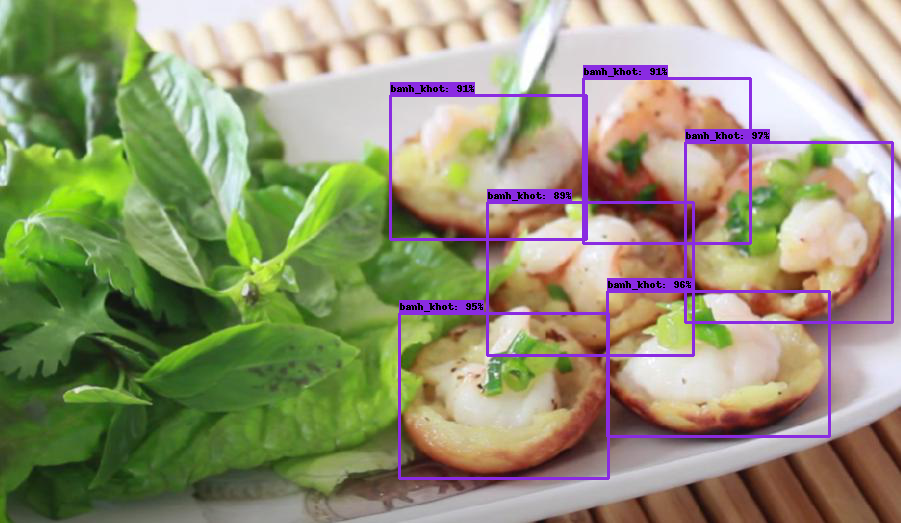

In [7]:
%cd /content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/source/SSD/models/research
category_index = label_map_util.create_category_index_from_labelmap("/content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/dataset/label/label_map.txt", use_display_name=True)
image_path = '/content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/dataset/data_training/images_test_jpg/img_1483.jpg'
image_np = load_image_into_numpy_array(image_path)
#image_np = cv2.resize(image_np, (320,320))
output_dict = run_inference_for_single_image(model, image_np)
print("Done inference")
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks_reframed', None),
    use_normalized_coordinates=True,
    line_thickness=3)
print("Done draw on image ")
display(Image.fromarray(image_np))

## Tiến hành detect với video

In [ ]:
import numpy as np
import cv2
count = 0
cap = cv2.VideoCapture('/content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/dataset/demo_default.mp4')
out = cv2.VideoWriter('/content/gdrive/MyDrive/DS201_DeepLearning_VNTF_22/dataset/result_predict_model/SSD_720.mp4',cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 30, (1280, 720))

# Check if camera opened successfully
if (cap.isOpened()== False):
  print("Error opening video stream or file")

# Read until video is completed
while (cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    frame = np.array(frame)

    if ret == True:
            video_dict = run_inference_for_single_image(model, frame)
            #Detect
            new_frame = vis_util.visualize_boxes_and_labels_on_image_array(
                        frame,
                        video_dict['detection_boxes'],
                        video_dict['detection_classes'],
                        video_dict['detection_scores'],
                        category_index,
                        instance_masks=output_dict.get('detection_masks_reframed', None),
                        use_normalized_coordinates=True,line_thickness=5)
            out.write(new_frame)
            count +=1
            print(count)
    # Break the loop
    else:
        break

# When everything done, release the video capture object
cap.release()
out.release()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
